# CMPT353-Project: Machine Learning and Stock Prediction  
Group: PokemonMaster  
Group menber:   
    Chi Yang,
    Yu Wang,
    Yue Fei
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import time

# Getting data  
Apple stock from 2009-10-31 to 2019-10-31

In [2]:
#Getting data
data = pd.read_csv('Stock_data/AAPL.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-11-02,27.114286,27.554285,26.510000,27.044285,23.531263,169745800
1,2009-11-03,26.835714,27.074286,26.559999,26.964285,23.461653,130635400
2,2009-11-04,27.247143,27.692858,27.175714,27.258572,23.717709,121882600
3,2009-11-05,27.485714,27.857143,27.402857,27.718571,24.117956,96200300
4,2009-11-06,27.501429,27.884285,27.485714,27.762857,24.156483,73774400


In [4]:
def strToDatetime(string):
    Datetime = datetime.datetime.strptime(string,'%Y-%m-%d')
    return Datetime

In [5]:
def to_timestamp(datetime):
    stamp = time.mktime(time.strptime(datetime.strftime('%Y-%m-%d'), '%Y-%m-%d'))
    return stamp

# Data clean  
String to Datetime & Datetime to timestamp

In [6]:
data['Date'] = data['Date'].apply(strToDatetime)
data['timestamp'] = data['Date'].apply(to_timestamp)

# Plot data

/Users/chiy/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


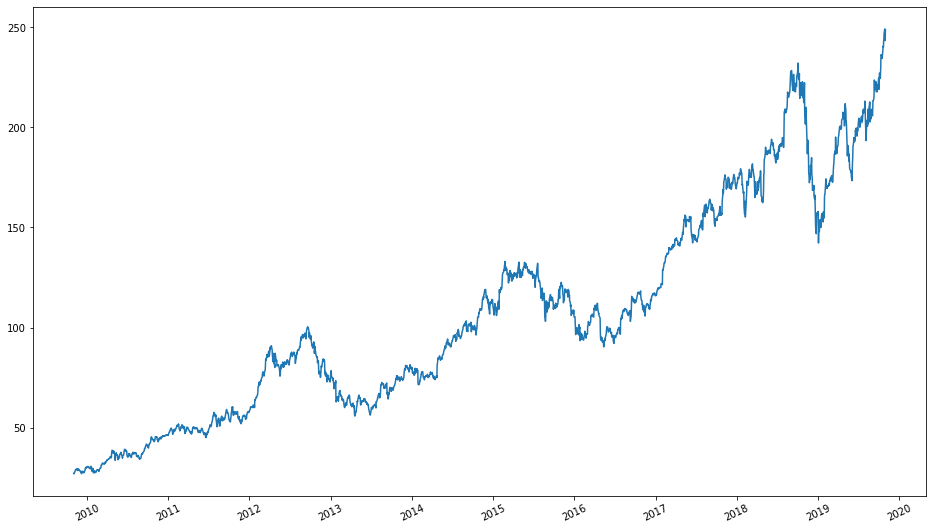

In [7]:
plt.figure(figsize=(16,9))
plt.xticks(rotation=25)
plt.plot(data['Date'],data['Close'])
plt.show()

# Plot the trend of stock

In [8]:
fit = stats.linregress(data['timestamp'], data['Close'])

In [9]:
data['prediction'] = fit.slope * data['timestamp'] + fit.intercept

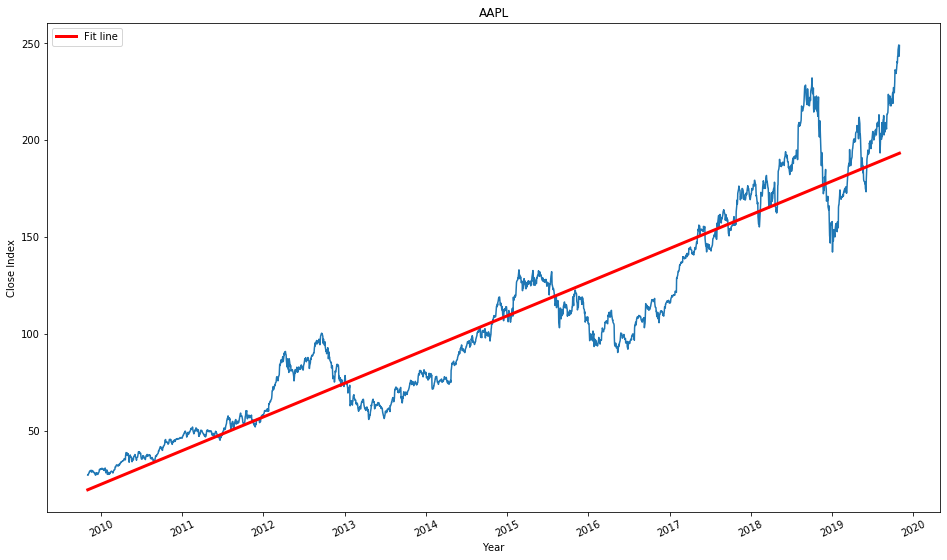

In [10]:
plt.figure(figsize=(16,9))
plt.xticks(rotation=25)
plt.title('AAPL')
plt.plot(data['Date'].values, data['Close'])
plt.plot(data['Date'].values, data['prediction'].values, 'r-', linewidth=3,label='Fit line')
plt.xlabel('Year')
plt.ylabel('Close Index')
plt.legend()
plt.show()

In [11]:
print('The slope of fit line is: {}'.format(fit.slope))

The slope of fit line is: 5.508476847205882e-07


# Machine learning for stock movement  
-Divide data to 75%(Train) & 25%(Valid)

In [12]:
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close','timestamp'])
new_data=data.loc[:,['Date','Close','timestamp']]

In [13]:
train = new_data[:1887]
valid = new_data[1887:] 

In [14]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [15]:
x_train = train.drop(['Close','Date'], axis=1)
y_train = train['Close']
x_valid = valid.drop(['Close','Date'], axis=1)
y_valid = valid['Close']
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

# Regression based on k-nearest neighbors

In [16]:
#import KNN modle
from sklearn.neighbors import KNeighborsRegressor

In [17]:
KNNmodel = KNeighborsRegressor(5)
KNNmodel.fit(x_train, y_train)
print("knn train score: {}\nknn valid score: {}".format(KNNmodel.score(x_valid, y_valid),(KNNmodel.score(x_train, y_train))))

knn train score: -17.67161281240557
knn valid score: 0.9988652761318435


In [18]:
# Predicting by knn-model：
valid['predict'] = KNNmodel.predict(x_valid)

/Users/chiy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


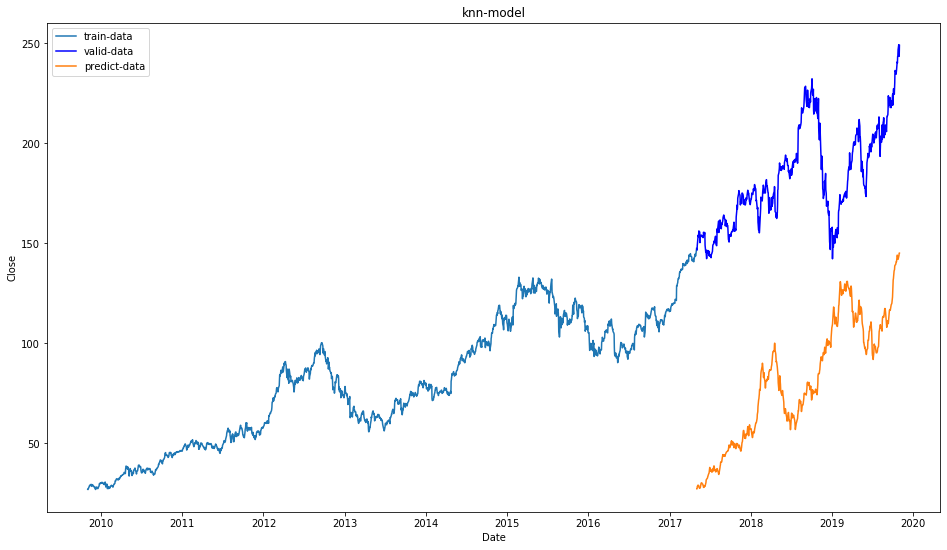

In [19]:
plt.figure(figsize=(16,9))
plt.title('knn-model')
plt.plot(train['Date'],train['Close'],label='train-data')
plt.plot(valid['Date'],valid['Close'],c = 'b',label='valid-data')
plt.plot(valid['Date'],valid['predict'],label='predict-data')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Epsilon-Support Vector Regression

In [20]:
#import SVM model
from sklearn.svm import SVR
SVRmodel = SVR(kernel='rbf', C=1, gamma='auto')
SVRmodel.fit(x_train, y_train)
print("SVR train score: {}\nSVR valid score: {}".format(SVRmodel.score(x_valid, y_valid),SVRmodel.score(x_train, y_train)))

SVR train score: -17.76734269548733
SVR valid score: 0.8273286203755501


In [21]:
valid['predict'] = SVRmodel.predict(x_valid)

/Users/chiy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


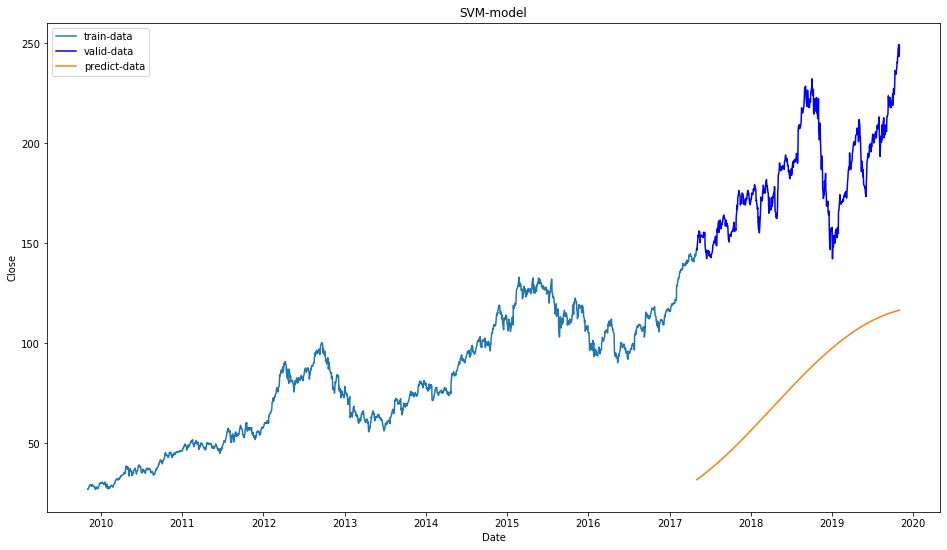

In [22]:
plt.figure(figsize=(16,9))
plt.title('SVM-model')
plt.plot(train['Date'],train['Close'],label='train-data')
plt.plot(valid['Date'],valid['Close'],c = 'b',label='valid-data')
plt.plot(valid['Date'],valid['predict'],label='predict-data')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Random forest regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor
RFmodel = RandomForestRegressor(30, max_depth=4)
RFmodel.fit(x_train, y_train)
print(RFmodel.score(x_valid, y_valid))
valid['predict'] = RFmodel.predict(x_valid)

-17.672277108808146


/Users/chiy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


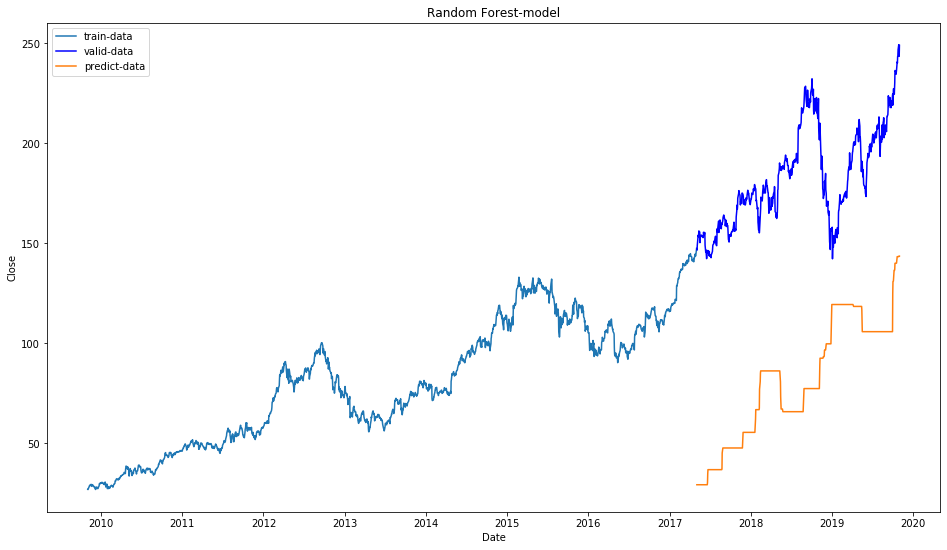

In [24]:
plt.figure(figsize=(16,9))
plt.title('Random Forest-model')
plt.plot(train['Date'],train['Close'],label='train-data')
plt.plot(valid['Date'],valid['Close'],c = 'b',label='valid-data')
plt.plot(valid['Date'],valid['predict'],label='predict-data')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Facebook's Prophet

In [25]:
import sys
print(sys.executable)

/Users/chiy/anaconda3/bin/python


In [26]:
# Using Facebook's Prophet to predict 
from fbprophet import Prophet

In [27]:
data1 = data.sort_index(ascending=True, axis=0).drop('prediction',axis = 1)

In [28]:
data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,timestamp
0,2009-11-02,27.114286,27.554285,26.510000,27.044285,23.531263,169745800,1.257149e+09
1,2009-11-03,26.835714,27.074286,26.559999,26.964285,23.461653,130635400,1.257235e+09
2,2009-11-04,27.247143,27.692858,27.175714,27.258572,23.717709,121882600,1.257322e+09
3,2009-11-05,27.485714,27.857143,27.402857,27.718571,24.117956,96200300,1.257408e+09
4,2009-11-06,27.501429,27.884285,27.485714,27.762857,24.156483,73774400,1.257494e+09


In [29]:
new_data1=data1.loc[:,['Date','Close']]
new_data1['Date'] = pd.to_datetime(new_data1.Date,format='%Y-%m-%d')
new_data1.index = new_data1['Date']

In [30]:
new_data1.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

In [31]:
# 75% train set and 25% valid set.
train = new_data1[:1887]
valid = new_data1[1887:]

In [32]:
Prophet_model = Prophet()
Prophet_model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
#predictions

close_prices = Prophet_model.make_future_dataframe(periods=len(valid))

forecast = Prophet_model.predict(close_prices)

In [34]:
forecast_valid = forecast['yhat'][1887:]
valid['Predictions'] = forecast_valid.values

/Users/chiy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



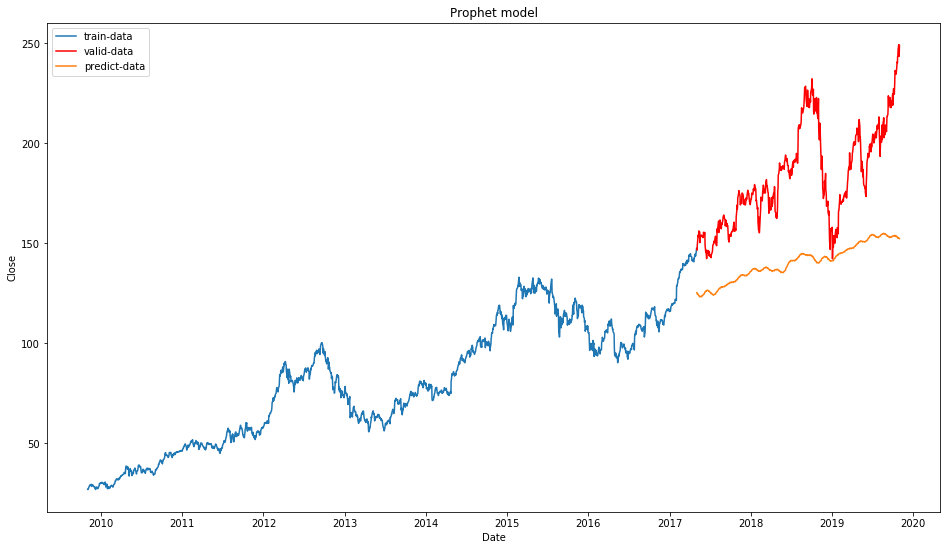

In [35]:
plt.figure(figsize=(16,9))
plt.title('Prophet model')
plt.plot(train['ds'].values,train['y'].values,label='train-data')
plt.plot(valid['ds'],valid['y'],c = 'r',label='valid-data')
plt.plot(valid['ds'],valid['Predictions'],label='predict-data')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Long Short-Term Memory 

In [36]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [37]:
data2 = data.sort_index(ascending=True, axis=0)

In [38]:
data2.index

RangeIndex(start=0, stop=2517, step=1)

In [39]:
new_data2=data2.loc[:,['Date','Close']]

In [40]:
new_data2.index = new_data2.Date
new_data2.drop(['Date'], axis=1, inplace=True)
dataset = new_data2.values

In [41]:
# 75% train set and 25% valid set.
train = dataset[0:1887,:]
valid = dataset[1887:,:]

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [43]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [44]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#len(x_train)

In [45]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [46]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/1
 - 243s - loss: 7.4875e-04


In [47]:
inputs = new_data2[len(new_data2) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [48]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [49]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


In [50]:
train = new_data2[:1887]
valid = new_data2[1887:]
valid['Predictions'] = closing_price


/Users/chiy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



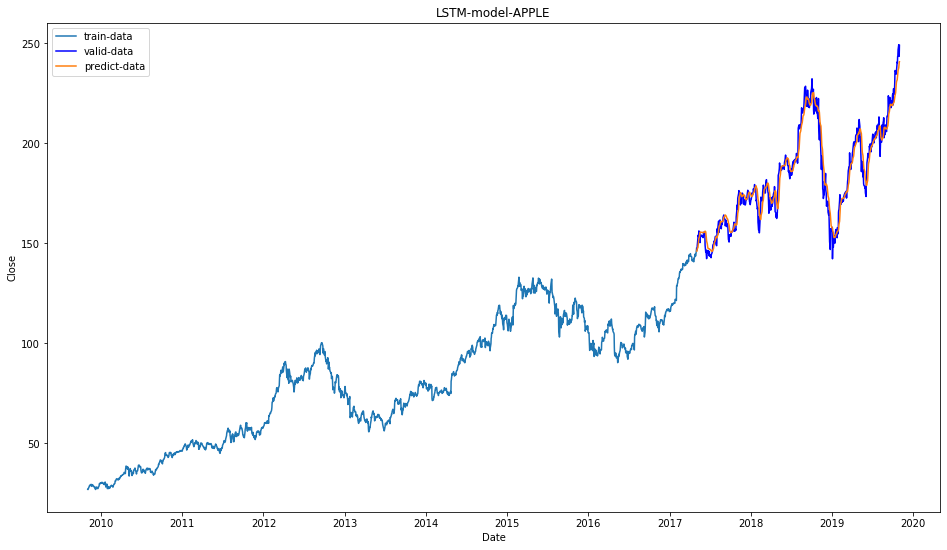

In [51]:
plt.figure(figsize=(16,9))
plt.title('LSTM-model-APPLE')
plt.plot(train['Close'],label='train-data')
plt.plot(valid['Close'],c = 'b',label='valid-data')
plt.plot(valid['Predictions'],label='predict-data')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()




# Using the LSTM_model to predict  stock movement in November  

-We used data before November to create this model.






In [52]:
# result is a null df 
result = pd.read_csv('Stock_data/predict_sample.csv').drop('1',axis = 1)
result.head()

,Data
0,2019-11-01
1,2019-11-04
2,2019-11-05
3,2019-11-07
4,2019-11-08


In [53]:
# n = the number of days you want to predict using LSTM model
n = 19
answer = []
for i in range(0,n):
    if i==0:
        inputs = new_data2[len(new_data2) - 60 + i:].values
        #inputs=x_valid.values
    else:
        inputs=new_data2[len(new_data2) - 60 + i:].values
        #print(answer[0:len(answer)])
        inputs=np.append(inputs,answer[0:len(answer)])
        #print(inputs)
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    X_test.append(inputs[0:60,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    answer.append(closing_price[0]) 

In [54]:
# Indert the predict data
result['predict'] = np.double(answer)

In [55]:
result.head()

,Data,predict
0,2019-11-01,241.382629
1,2019-11-04,241.473953
2,2019-11-05,241.244415
3,2019-11-07,240.822220
4,2019-11-08,240.291748


# Comparing with the real data

In [56]:
real_data = pd.read_csv('Stock_data/AAPL_test.csv').loc[:,['Date','Close']]
real_data['Date'] = pd.to_datetime(real_data.Date,format='%Y-%m-%d')
result['Data'] = pd.to_datetime(result.Data,format='%Y-%m-%d')

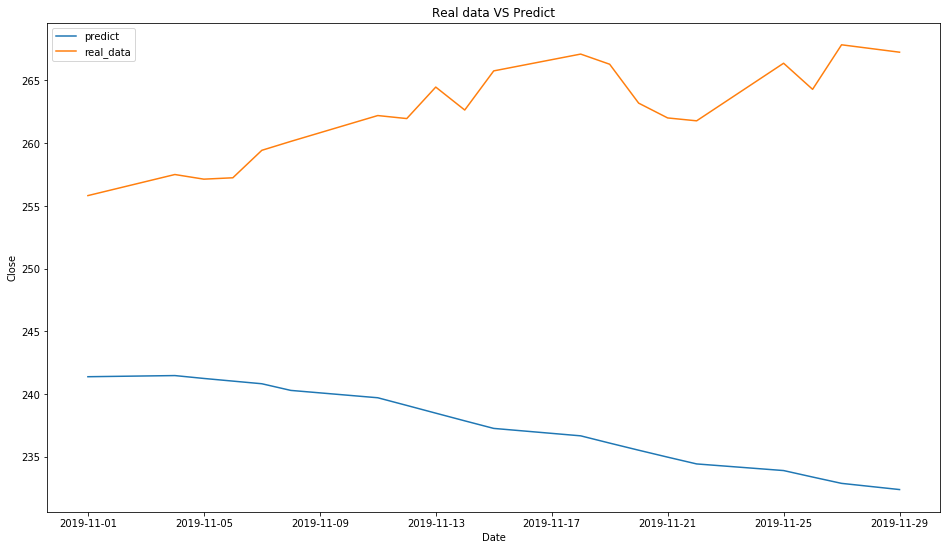

In [57]:
plt.figure(figsize=(16,9))
plt.title("Real data VS Predict")
plt.plot(result.Data,result.predict,label = 'predict')
plt.plot(real_data.Date,real_data.Close,label = 'real_data')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.savefig('Real_data VS Predict.png')
plt.show()